# Ortogonal Gradient Vectors

Our well known support functions from previous excercises (I'm not referencing them as this is an WIP effort to learn, so each file may have slight improvements / differences that I'm leaving there for future reference and nostalgia :)

In [142]:
from PIL import Image, ImageFilter, ImageDraw
import numpy as np

def toGris(image, std=601, returnArr=False):
    
    m=np.array(image)
    
    rec601 = (0.29894, 0.58704, 0.11402)
    rec709 = (0.2126, 0.7152, 0.0722)
    
    recStandard = rec601 if (std == 601) else rec709
    
    matrixCols = m.shape[0]
    matrixRows = m.shape[1]
    
    np_im = np.zeros((matrixCols,matrixRows))
    for i in range(matrixCols):
        for j in range(matrixRows):
            #convert to GreyScale (only RGB suppoted at the momment)
            np_im[i,j] = round(m[i,j,0] * recStandard[0])
            np_im[i,j] += round(m[i,j,1] * recStandard[1])
            np_im[i,j] += round(m[i,j,2] * recStandard[2])
            
            
    print(np_im.shape)
    print("min val: %s max val: %s" % (np_im.min(),np_im.max()))
    print("Using standard: rec%s" % (std))

    if (returnArr):
        return np_im
    else:
        return Image.fromarray(np_im.astype(np.uint8))
    
#Function to "flip" de Kernell for convolution
def flipKernel(k):
    #Get array shape
    filas = k.shape[0]
    columnas = k.shape[1]
    
    #Create resulting array
    r = np.zeros((filas, columnas))
    #print(r)
    
    #support vars
    i = j = 0
    n = m = 0
    
    for x in k:
        for val in x:
            #print(k[i,j])
            n = filas-1-i
            m = columnas-1-j
            #print("Val: %s fila: %s Col: %s" % (val, n, m))
            r[n,m] = val
            
            if (j < columnas-1):
                j = j+1
            else:
                i += 1
                j = 0
    return r

def frameWithZeros(image, kernel):
    kR = kernel.shape[0]//2
    kC = kernel.shape[1]//2
    
    #new shape to ensure resulting image is the expected size
    sR = np.zeros((image.shape[0],kR))
    nH = np.hstack((sR,image,sR))
    sC = np.zeros((kC,nH.shape[1]))
    nH = np.vstack((sC,nH,sC))
    
    return nH


def applyKernelToSegment(kernel, segment, pos):
    x = pos[0]
    y = pos[1]
    kR = kernel.shape[0]//2
    kC = kernel.shape[1]//2
    
    r = 0
    
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            r = r + (kernel[i,j] * segment[(x + (i-kR),y + (j-kC))])
       
    return r

def normaliza(np_image, treshold=90):
    scaleMax = 255 #assuming 0 - 255 resulting scale
    minval = np_image.min()
    maxval = np_image.max()
    
    r = np.zeros((np_image.shape))
    
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            tm = np.floor((np_image[i,j] + maxval) * scaleMax / (maxval - minval))
            r[i,j] = tm if (tm > treshold) else 0
            
    return r

def applyKernel(image, kernel, returnArr=False, treshold =140, norm=True):
    np_image = np.array(image)
    kR = kernel.shape[0]//2
    kC = kernel.shape[1]//2
    r = np.zeros((np_image.shape))
    
    nImage = frameWithZeros(np_image, kernel)
    
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            #print(applyKernel(w, nH, (i+kR,j+kC)))
            r[i,j] = applyKernelToSegment(flipKernel(kernel), nImage, (i+kR,j+kC))
            
    if (returnArr):
        if(norm):
            return normaliza(r, treshold)  
        else:
            return r  
    else:
        return Image.fromarray(normaliza(r, treshold).astype(np.uint8))


### Load image

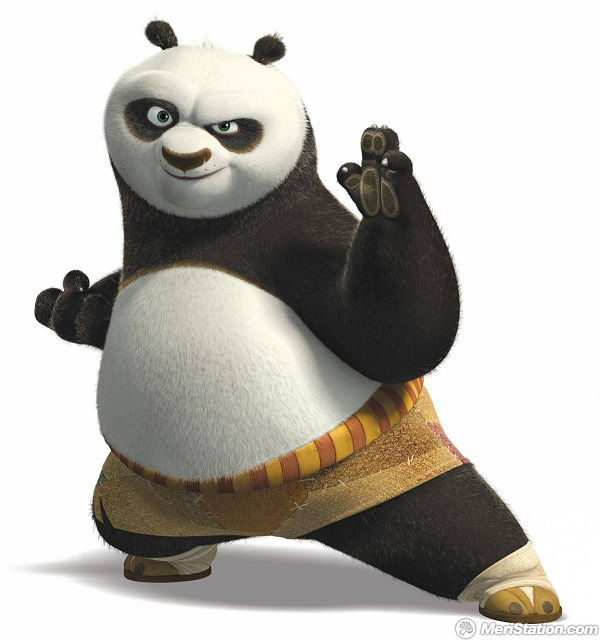

In [143]:
img = Image.open("panda.jpg")
img

## Convert to gray scale

In [144]:
gray_panda = toGris(img)

(640, 600)
min val: 2.0 max val: 255.0
Using standard: rec601


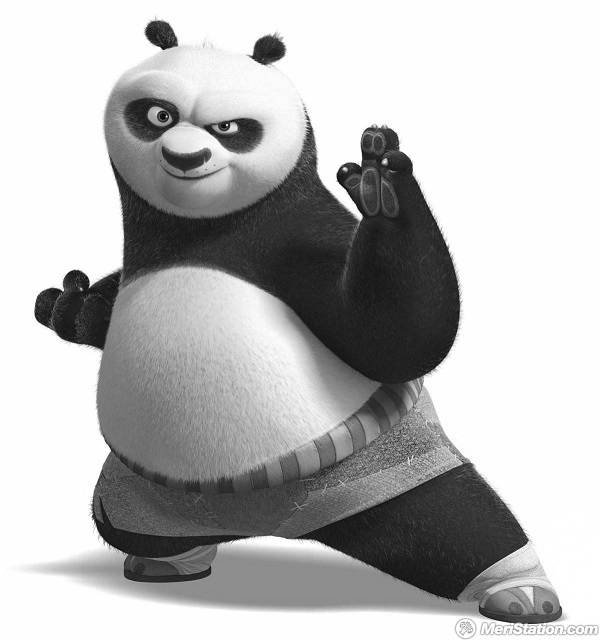

In [145]:
gray_panda

## Calculcate Gradient (dx and dy)

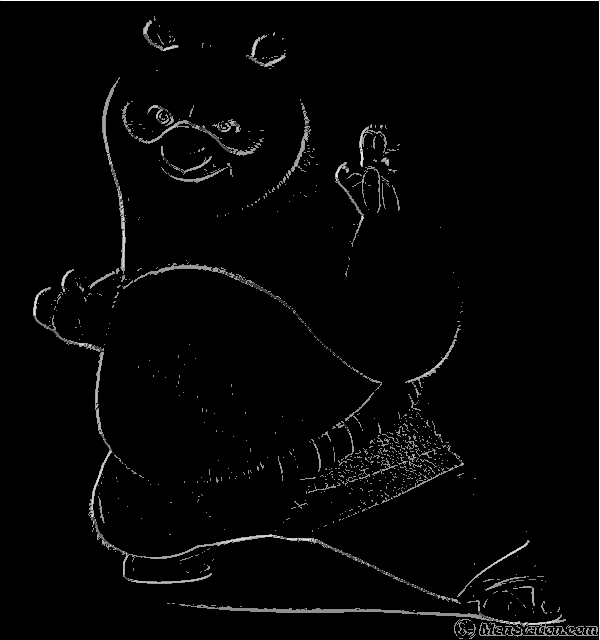

In [146]:
sobelx = np.array([[-1,0,1],
                  [-2,0,2],
                  [-1,0,1]])

sobely = np.array([[1,2,1],
                   [0,0,0],
                   [-1,-2,-1]])

sx = applyKernel(gray_panda, sobelx)
sy = applyKernel(gray_panda, sobely)
sobel_panda = Image.fromarray(np.array(sx)+np.array(sy))
sobel_panda

In [148]:
Ix = applyKernel(gauss_panda, sobelx,1)
Iy = applyKernel(gauss_panda, sobely,1)

print("Ix min: %s Ix max: %s" % (Ix.min(), Ix.max()))
print("Iy min: %s Iy max: %s" % (Iy.min(), Iy.max()))

Ix min: 0.0 Ix max: 255.0
Iy min: 0.0 Iy max: 254.0


In [149]:
G = np.sqrt(np.square(Ix)+np.square(Iy))
G = abs(G)
G

array([[222.        , 254.        , 254.        , ..., 254.        ,
        254.        , 314.66331213],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 255.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 255.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 253.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 254.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 223.        ]])

In [150]:
#Gradiente magnitude
G = np.hypot(Ix,Iy)
G

array([[222.        , 254.        , 254.        , ..., 254.        ,
        254.        , 314.66331213],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 255.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 255.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 253.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 254.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 223.        ]])

In [151]:
G = G / G.max() * 255
G

array([[179.90657893, 205.83905878, 205.83905878, ..., 205.83905878,
        205.83905878, 255.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 206.64944877],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 206.64944877],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 205.02866878],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 205.83905878],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 180.71696893]])

## Calculate Theta...

### Important if you return np.uint8 you will lost negative values... so modifying a bit the applyKernel funct

In [152]:
#slope theta
tIx = applyKernel(gauss_panda, sobelx,1,140,0)
tIy = applyKernel(gauss_panda, sobely,1,140,0)
theta = np.arctan2(tIy,tIx)
theta

array([[ 2.35619449,  1.57079633,  1.57079633, ...,  1.57079633,
         1.57079633,  0.78539816],
       [ 3.14159265,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.14159265,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.14159265,  0.        ,  0.        , ...,  1.91956733,
         1.98902066,  0.01096666],
       [ 3.14159265,  0.        ,  0.        , ...,  1.93797016,
         1.99742382,  0.00692373],
       [-2.35619449, -1.57079633, -1.57079633, ..., -1.57376956,
        -1.57376368, -0.78408237]])

### Confirming all looks good ...

#### Pro tip it saves A LOT of time to graph / print shape and values to confirm data looks as it should...

In [153]:
print(theta.shape)
print(theta.min())
print(theta.max())

(640, 600)
-3.1396241521954353
3.141592653589793


### As I'm using PIL "normalizing" to just 8 possible angles...

In [154]:
deg = np.rad2deg(theta)
print("Deg min %s max %s"% (deg.min(),deg.max()))
di,dj = deg.shape

#for i in range(di):
#    for j in range(dj):
#        if deg[i,j] < 0: deg[i,j] = 360 + deg[i,j]
#print("Deg min %s max %s"% (deg.min(),deg.max()))

for i in range(di):
    for j in range(dj):
        if deg[i,j] < 0: deg[i,j] = 360 + deg[i,j]
        
        if (deg[i,j] < 20): deg[i,j] = 0
        elif (deg[i,j] < 65): deg[i,j] = 45
        elif (deg[i,j] < 110): deg[i,j] = 90
        elif (deg[i,j] < 155): deg[i,j] = 135
        elif (deg[i,j] < 200): deg[i,j] = 180
        elif (deg[i,j] < 245): deg[i,j] = 225
        elif (deg[i,j] < 290): deg[i,j] = 270
        elif (deg[i,j] < 335): deg[i,j] = 315
        else: deg[i,j] = 0

print("Deg min %s max %s"% (deg.min(),deg.max()))

Deg min -179.88721317813767 max 180.0
Deg min 0.0 max 315.0


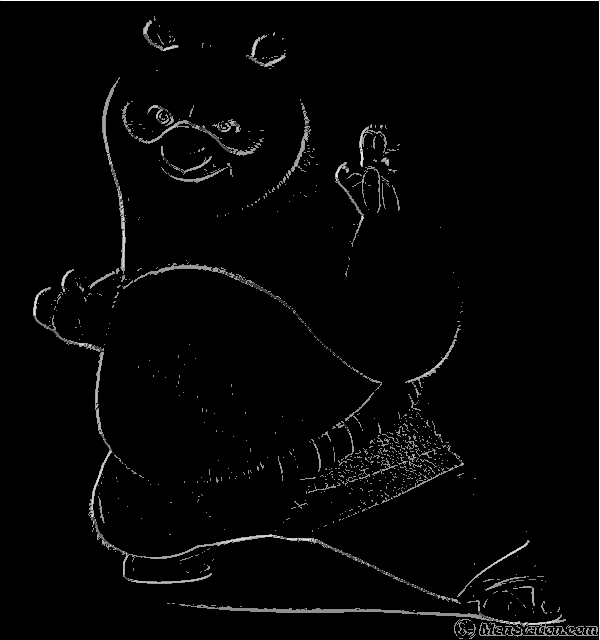

In [155]:
sobel_panda

### And finally the fun, we print each of the ortogonal gradients taking the angle direction from the deg matrix that is "Theta" matrix (rads) to deg

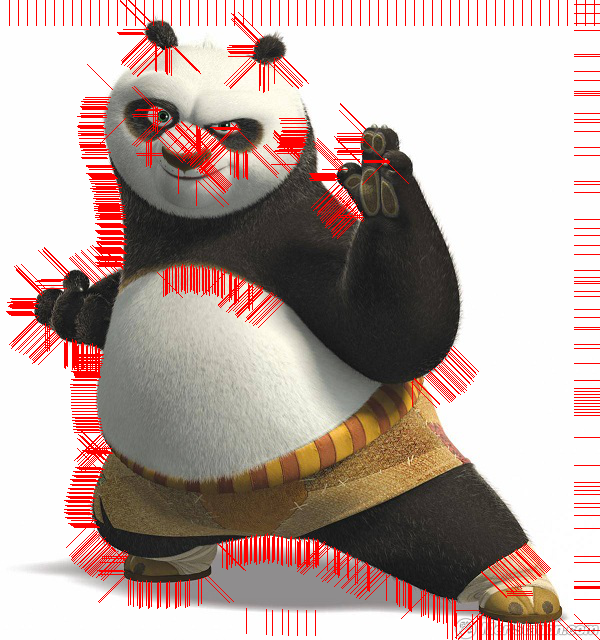

In [162]:
gray_panda = Image.open("pandaGris.jpg")
color_panda = Image.open("panda.jpg")
np_panda = np.array(gray_panda)


test = ImageDraw.Draw(color_panda)
#test.line([(500, 500), (1, 1)] , fill="white", width=2)
c,r = np_panda.shape
paint_step = 9
ii = 0

def calculaTheta(ang, size=25):
    
    if ang < 0 : ang = 360 + ang
    
    if (ang < 20): return (-size,0) #0 deg
    elif (ang < 65): return (-size,+size) # 45 deg
    elif (ang < 110): return (0, +size) # 90 deg
    elif (ang < 155): return (+size, +size) # 135 deg
    elif (ang < 200): return (+size, 0) # 180 deg
    elif (ang < 245): return (+size, size) # 225 deg
    elif (ang < 290): return (0, size) # 270 deg
    elif (ang < 335): return (-size, -size) # 315 deg
    else: ang = 0

for i in range(c):
    for j in range(r):
        if(G[i, j] > 100):
            if(ii == paint_step):
                thetaj, thetai = calculaTheta(deg[i,j]) 
                test.line([(j, i), (j+thetaj, i+thetai)] , fill="#ff0000", width=1)
                ii=0
            ii+=1
                
#Image.fromarray(play)
color_panda